In [1]:
import numpy as np
import os,math,cv2, h5py
import tensorflow as tf
from collections import defaultdict
from scipy import misc

from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
from random import shuffle
from sklearn.cluster import MiniBatchKMeans

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#load alex net and VGG-16 weights
# download VGG-16 from ftp://mi.eng.cam.ac.uk/pub/mttt2/models/vgg16.npy and save under tf_models/
# download Alex Net from http://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy and save under tf_models/

alex_net_path = os.path.join("tf_models/bvlc_alexnet.npy")
alex_net = np.load(alex_net_path, encoding='latin1').item()

vgg_net_path = os.path.join("tf_models/vgg16.npy")
vgg_net = np.load(vgg_net_path, encoding='latin1').item()
print(alex_net.keys())
print(vgg_net.keys())

dict_keys(['conv5', 'conv4', 'fc8', 'conv2', 'conv3', 'fc6', 'fc7', 'conv1'])
dict_keys(['conv2_1', 'conv4_3', 'conv2_2', 'conv1_2', 'conv5_3', 'conv3_2', 'fc7', 'conv4_1', 'fc8', 'conv5_2', 'conv3_1', 'conv1_1', 'conv4_2', 'fc6', 'conv5_1', 'conv3_3'])


In [3]:
a_c1 = alex_net['conv1']
w1 = a_c1[0]
b1 = a_c1[1]
print(w1.shape)

(11, 11, 3, 96)


In [4]:
#Needed for creating feature descriptors
def max_pool(input_x, kernel_size, stride, padding='VALID'):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input_x, ksize=ksize, strides=strides, padding=padding)

#Here we already have pre-trained weights
def conv_2d(input_x, weights, stride, bias=None, padding='VALID'):
    stride_shape = [1, stride, stride, 1]
    c = tf.nn.conv2d(input_x, weights, stride_shape, padding=padding)
    if bias is not None:
        c += bias
    return c
     

In [5]:

def imgread(path):
    print("Image:", path.split("/")[-1])
    # Read in the image using python opencv
    img = cv2.imread(path)
    img = img / 255.0
    print("Raw Image Shape: ", img.shape)
    
    # Center crop the image
    short_edge = min(img.shape[:2])
    W, H, C = img.shape
    to_crop = min(W, H)
    cent_w = int((img.shape[1] - short_edge) / 2)
    cent_h = int((img.shape[0] - short_edge) / 2)
    img_cropped = img[cent_h:cent_h+to_crop, cent_w:cent_w+to_crop]
    print("Cropped Image Shape: ", img_cropped.shape)
    
    # Resize the cropped image to 224 by 224 for VGG16 network
    img_resized = cv2.resize(img_cropped, (224, 224), interpolation=cv2.INTER_LINEAR)
    print("Resized Image Shape: ", img_resized.shape)
    return img_resized

In [6]:
#center crop and resize
image_path = os.path.join("images/corgi.jpg")
img1 = imgread(image_path)

#basic cv resize
img2 = cv2.imread(image_path)
img_resized = cv2.resize(img2, (224, 224), interpolation=cv2.INTER_LINEAR)

Image: corgi.jpg
Raw Image Shape:  (600, 900, 3)
Cropped Image Shape:  (600, 600, 3)
Resized Image Shape:  (224, 224, 3)


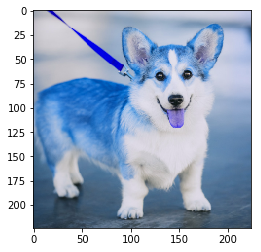

In [7]:
plt.imshow(img1)
plt.show()

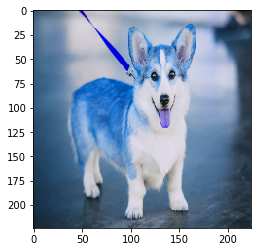

In [8]:
plt.imshow(img_resized)
plt.show()

In [9]:
#Testing Cell Block
ip = tf.Variable(tf.random_normal([1,3,3,5]))
ft = tf.Variable(tf.random_normal([1,1,5,1]))

op = tf.nn.conv2d(ip, ft, strides=[1, 1, 1, 1], padding='VALID')
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Usage passing the session explicitly.
    #print(op.eval(sess))
    #
    ip, op = sess.run([ip, op])
    print(op)


[[[[-1.60078931]
   [ 4.55651522]
   [-0.51797724]]

  [[ 3.88332319]
   [ 2.9083457 ]
   [ 0.70771211]]

  [[-2.75426221]
   [-0.15782976]
   [-3.07595754]]]]


In [10]:
#Testing Cell block
#For generating single descriptor from each convolution layer
tf.reset_default_graph()
images = tf.placeholder(tf.float32, [None, 224, 224, 3])
w = tf.get_variable('we', initializer=tf.to_float(w1))
print(images.get_shape(), w.get_shape())

c1 = conv_2d(images, w, 4, b1)
img1 = img1.reshape(1, 224, 224, 3) # convert to 4D tensor

(?, 224, 224, 3) (11, 11, 3, 96)


In [11]:
#Testing Cell block
#tf.reset_default_graph()
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    # Usage passing the session explicitly.
    #print(op.eval(sess))
    #
    conv_op = sess.run([c1], feed_dict={images: img1})
    print(conv_op[0].shape)

(1, 54, 54, 96)


In [12]:
def normalize(ip):
    m2 = np.min(ip)
    ip = ip - m2
    m1 = np.max(ip)
    ip = ip / m1
    return ip

In [13]:
def alex_net_graph(ip, weights, biases):
    w1, w2, w3, w4, w5 = weights
    b1, b2, b3, b4, b5 = biases
    with tf.variable_scope("alex_net"):
        #CONV 1
        c1 = conv_2d(ip, w1, 4, b1, padding='VALID')
        r1 = tf.nn.relu(c1)
        m1 = max_pool(r1, 3, 2, padding='VALID')
        #print("M1", m1.get_shape)
        
        #CONV2
        m1 = tf.pad(m1, [[0, 0], [2, 2], [2, 2], [0, 0]], "CONSTANT") # add 2 padding
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=m1)
        w2_1, w2_2 = tf.split(axis = 3, num_or_size_splits=2, value=w2)
        o1 = conv_2d(i1, w2_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w2_2, 1, bias=None, padding='SAME')
        c2 = tf.concat(axis = 3, values = [o1,o2])
        r2 = tf.nn.relu(c2)
        m2 = max_pool(r2, 3, 2, padding='VALID')
        #print("M2",m2.get_shape)
        
        #CONV3
        c3 = conv_2d(m2, w3, 1, b3)
        r3 = tf.nn.relu(c3)
        #print(r3.get_shape, "R3")
        
        #CONV4
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=r3)
        w4_1, w4_2 = tf.split(axis = 3, num_or_size_splits=2, value=w4)
        o1 = conv_2d(i1, w4_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w4_2, 1, bias=None, padding='SAME')
        c4 = tf.concat(axis = 3, values = [o1,o2])
        r4 = tf.nn.relu(c4)
        #print(r4.get_shape, "R4")
        
        #CONV5
        i1, i2 = tf.split(axis = 3, num_or_size_splits=2, value=r4)
        w5_1, w5_2 = tf.split(axis = 3, num_or_size_splits=2, value=w5)
        o1 = conv_2d(i1, w5_1, 1, bias=None, padding='SAME')
        o2 = conv_2d(i2, w5_2, 1, bias=None, padding='SAME')
        c5 = tf.concat(axis = 3, values = [o1,o2])
        r5 = tf.nn.relu(c5)
        m5 = max_pool(r5, 3, 2, padding='VALID')
        #print(m5.get_shape, "M5")
        
        layers = [m1,m2,r3,r4,m5]
        return layers

        
        #c1 = conv_2d(ip, w1, 4, b1, padding='VALID')
        #print("C1", c1.get_shape)
        #c2 = conv_2d(c1, w2, 1, b2)
        


In [14]:
#takes an input image and generates a feature descriptor from the image
def features_alex_net(inputs, alex_net):
    tf.reset_default_graph()
    H,W,D = 227, 227, 3
    
    w1, b1 = alex_net['conv1'][0], alex_net['conv1'][1]
    w2, b2 = alex_net['conv2'][0], alex_net['conv2'][1]
    w3, b3 = alex_net['conv3'][0], alex_net['conv3'][1]
    w4, b4 = alex_net['conv4'][0], alex_net['conv4'][1]
    w5, b5 = alex_net['conv5'][0], alex_net['conv5'][1]
    
    weights = [w1,w2,w3,w4,w5]
    biases = [b1,b2,b3,b4,b5]
    
    #print(w1.shape, w2.shape, w3.shape, w4.shape, w5.shape)
    
    images = tf.placeholder(tf.float32, [None, H, W, D])
    input_layers = alex_net_graph(images, weights, biases)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        result  = sess.run(input_layers, feed_dict={images: inputs})
        return result

In [15]:
#testing cell block
H,W,D = 227, 227, 3
i1 = cv2.imread(os.path.join("images/corgi.jpg"))
i1 = cv2.resize(i1, (H, W), interpolation=cv2.INTER_LINEAR)
i2 = cv2.imread(os.path.join("images/dog.png"))
i2 = cv2.resize(i2, (H, W), interpolation=cv2.INTER_LINEAR)
i3 = cv2.imread(os.path.join("/home/chinmay/CODE/gumgum/NDVD/dataset/sample.jpg"))
i3 = cv2.resize(i3, (H, W), interpolation=cv2.INTER_LINEAR)
images = np.asarray([i1,i2,i3])

conv1, conv2, conv3, conv4, conv5 = features_alex_net(images, alex_net)

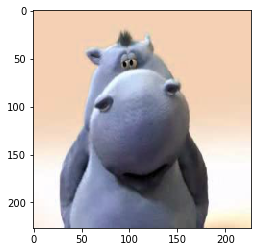

In [16]:
plt.imshow(i3)
plt.show()

In [17]:
print(conv1.shape, conv2.shape, conv3.shape, conv4.shape, conv5.shape)

(3, 31, 31, 96) (3, 15, 15, 256) (3, 13, 13, 384) (3, 13, 13, 384) (3, 6, 6, 256)


In [18]:
print(np.amax(conv1, axis=(1,2)).shape)

(3, 96)


In [19]:
#apply max pooling per channel
# m1.. m5 are layer level image feature descriptors
m1 = np.amax(conv1, axis=(1,2))
m2 = np.amax(conv2, axis=(1,2))
m3 = np.amax(conv3, axis=(1,2))
m4 = np.amax(conv4, axis=(1,2))
m5 = np.amax(conv5, axis=(1,2))

In [20]:
# as mentioned in paper, we get a vector of 1376
print(m1.shape, m2.shape)
r = np.concatenate((m1,m2,m3,m4,m5), axis=1)
print(r.shape)

(3, 96) (3, 256)
(3, 1376)


In [21]:
#add zero mean and normalization

In [22]:
query_videos = set([1, 815, 1412, 1849, 2200, 2604, 3387, 3752, 4304, 4543, 4849, 5229, 6125, 6545, 6653, 8449, 8659, 9310, 9813,
               10382, 10580, 11047, 11466, 12818])

In [23]:
# create codebook from the video keyframes (from all or sample some 100K frames).
# Use above query videos, to generate visual words and find nearest visual word. 

# Get all videos having any common visual word. Calculate cosine similarity between query pairs
'''
Loop through the dataset 
    get alexNet feature vector for each frame.
    V = store video level feature vector for each frame.

    D = store complete feature vectors for all dataset (do not include query videos)
'''

'\nLoop through the dataset \n    get alexNet feature vector for each frame.\n    V = store video level feature vector for each frame.\n\n    D = store complete feature vectors for all dataset (do not include query videos)\n'

In [37]:
KEYFRAME_DATA_PATH = '/home/chinmay/CODE/gumgum/NDVD/repo/Near-Duplicate-Video-Detection/dataset/key_frames/'
KEYFRAME_META_PATH = './dataset/Shot_Info.txt'
TOTAL_FRAMES = 398008
TOTAL_VIDEOS = 13129
sample_size = 100000
H,W,D = 227, 227, 3
shot_data = defaultdict(int)
img_data = defaultdict(list)
sequence_data = [0 for i in range(TOTAL_FRAMES)]
video_data = defaultdict(list)
k = 0

with open(KEYFRAME_META_PATH) as f:
    for line in f:
        serial_id, key_frame, video_id, video_name = line.split('\t')
        video_id = int(video_id)
        if len(img_data[video_id]) == 0:
            img_data[video_id] = [0]
        else:
            img_data[video_id].append(0)
            
        if len(video_data[video_id]) == 0:
            video_data[video_id] = [key_frame]
        else:
            video_data[video_id].append(key_frame)
            
        shot_data[video_id] += 1
        sequence_data[k] = [video_id, key_frame]
        k += 1

In [41]:
video_data[1]
print(video_data[2])
print("OK")

['2_1_RKF', '2_2_RKF', '2_3_RKF', '2_4_RKF', '2_5_RKF', '2_6_RKF', '2_7_RKF']
OK


In [49]:
def get_keyframes(path):
    for subdir, pdir, files in os.walk(path):
        for fname in files:
            filepath = os.path.join(os.sep, subdir, fname)
            if filepath.endswith('.jpg'):
                name,extension = os.path.splitext(fname)
                vid, seq, shot = name.split('_')
                vid, seq  = int(vid), int(seq)
                yield vid, seq, misc.imread(filepath)

def get_frame(vid, frame):
    ipath = KEYFRAME_DATA_PATH + str(vid) + "/" + frame + ".jpg"
    try:
        img = misc.imread(ipath)
    except FileNotFoundError:
        return None
    return img


def get_video_frames(vid, frames, resize = True):
    ipath = KEYFRAME_DATA_PATH + str(vid) + "/"
    images = []
    for f in frames:
        try:
            k = ipath + f + ".jpg"
            img = misc.imread(k)
            img = cv2.resize(img, (H, W), interpolation=cv2.INTER_LINEAR)
            images.append(img)
        except FileNotFoundError:
            continue
    return images            

In [30]:
#CODEBOOK generation
# generate codebook from 100K sample frames


f = [i for i in range(TOTAL_FRAMES)]
shuffle(f)
code_frames = f[:sample_size]
#code_frames = f[:100000]
batch_size = 5000
clusters = 1000
code_size = 100



In [31]:
code_frames[10]
f = 10
d = get_frame(sequence_data[f][0], sequence_data[f][1])
d.shape

(240, 320, 3)

In [32]:
#Mini-batch k means to generate visual codebook

rng = np.random.RandomState(0)
kmeans = MiniBatchKMeans(n_clusters=clusters, random_state=rng, init='k-means++',verbose=True)

it = 0

batch_data = []
for f in code_frames:
    vid, frame = sequence_data[f][0], sequence_data[f][1]
    img = get_frame(vid, frame)
    if img is None:
        continue
    img = cv2.resize(img, (H, W), interpolation=cv2.INTER_LINEAR)
    if vid in query_videos: # DO NOT add query videos
        continue

    batch_data.append(img)
    
    if len(batch_data) == batch_size:
        it += 1
        print("Iteration", it)
        
        '''
        batch_data = np.asarray(batch_data)
        #print(data.shape, data[0].shape)

        conv1, conv2, conv3, conv4, conv5 = features_alex_net(batch_data, alex_net)
        #Apply max pooling
        m1 = np.amax(conv1, axis=(1,2))
        m2 = np.amax(conv2, axis=(1,2))
        m3 = np.amax(conv3, axis=(1,2))
        m4 = np.amax(conv4, axis=(1,2))
        m5 = np.amax(conv5, axis=(1,2))

        r = np.concatenate((m1,m2,m3,m4,m5), axis=1)
        print(type(r[0][0]), r.shape)
        #zero-mean and unit normalize
        
        kmeans.partial_fit(r)
        
        batch_data = []
        '''
        
        batch_data = np.asarray(batch_data)
        batch_res = []
        #print(data.shape, data[0].shape)
        for k in range(0,len(batch_data) // code_size):
            conv1, conv2, conv3, conv4, conv5 = features_alex_net(batch_data[k*code_size:(k+1)*code_size], alex_net)
            #Apply max pooling
            m1 = np.amax(conv1, axis=(1,2))
            m2 = np.amax(conv2, axis=(1,2))
            m3 = np.amax(conv3, axis=(1,2))
            m4 = np.amax(conv4, axis=(1,2))
            m5 = np.amax(conv5, axis=(1,2))

            r = np.concatenate((m1,m2,m3,m4,m5), axis=1)
            
            #zero-mean and unit normalize
            
            if len(batch_res) == 0:
                batch_res = r
            else:
                batch_res = np.concatenate((batch_res, r), axis=0)
                #print(type(r), batch_res.shape, "IN", r.shape)
        
        #print(type(r[0][0]), batch_res.shape, "OUT")
        kmeans.partial_fit(batch_res)
        batch_data, batch_res = [], []

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19


In [34]:
#test k means
kmeans.cluster_centers_

array([[  173.49281311,   894.34222412,   158.61257935, ...,
           33.8102684 ,    43.51404953,   113.91932678],
       [  180.04449463,  1197.26123047,   258.06710815, ...,
          104.08734131,    39.04030228,    79.15987396],
       [  174.3054657 ,  1306.70959473,   276.17788696, ...,
           69.40855408,    43.46239853,   309.59402466],
       ..., 
       [  206.17218018,   865.44750977,   206.34562683, ...,
           17.19708061,    36.36001587,   102.49700928],
       [  244.62928772,  1171.09533691,   345.43469238, ...,
           23.58573532,   200.78440857,   343.5852356 ],
       [  281.01260376,  1344.85217285,   271.96255493, ...,
           60.98352051,   365.63153076,   195.86688232]], dtype=float32)

In [35]:
import pickle
pickle.dump(kmeans, open('kmeans++_clusters.pkl', 'wb'))

In [64]:
#Generate video level histograms
video_hist = [[0 for i in range(clusters)] for i in range(TOTAL_VIDEOS)]

dataset = range(1,TOTAL_VIDEOS+1)
#dataset = range(1,10+1)
batch_data, vid_data, seq_data = [], [], []
it = 0
for d in dataset:
    vid = d
    frames = video_data[d]
    if vid in query_videos: # DO NOT add query videos
        continue
        
    images = get_video_frames(vid, frames)
    it += 1
    if it %100 == 0:
        print("Iteration", it)
    batch_data = np.asarray(images)
    #print(len(batch_data), vid)
    
    if len(batch_data) == 0:
        continue
    batch_res = []

    conv1, conv2, conv3, conv4, conv5 = features_alex_net(batch_data, alex_net)
    #Apply max pooling
    m1 = np.amax(conv1, axis=(1,2))
    m2 = np.amax(conv2, axis=(1,2))
    m3 = np.amax(conv3, axis=(1,2))
    m4 = np.amax(conv4, axis=(1,2))
    m5 = np.amax(conv5, axis=(1,2))

    r = np.concatenate((m1,m2,m3,m4,m5), axis=1)

    #zero-mean and unit normalize 
    kmeans.verbose = False
    y = kmeans.predict(r)
    for nearest_neighbour in y:
        video_hist[vid][nearest_neighbour] += 1
    #print(video_hist[vid])
    batch_data, r = [], []
    
    

Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
Iteration 6000
Iteration 6100
Iteration 6200
Iteration 6300
Iteration 6400
Iteration 6500
Iteration 6600
Iteration 6700
Iter

IndexError: list index out of range

In [65]:
pickle.dump(video_hist, open('video_hist.pkl', 'wb'))

In [70]:
#calculate tf-idf weights
#calculate inverted file index for words

import math
inverse_word_count = defaultdict(int)
total_word_count = 0
idf = [0 for i in range(clusters)]
inverted_index = {}

normal_vhist = [[]]
for i in range(1,TOTAL_VIDEOS):
    for index,val in enumerate(video_hist[i]):
        if val > 0:
            inverse_word_count[index] += val
            total_word_count += val
            
            s = inverted_index.get(index)
            if s is None:
                inverted_index[index] = set([i])
            else:
                inverted_index[index].add(i)
            
    k = np.array(video_hist[i], dtype=np.float32)
    #normalize TF
    x = sum(k)
    if x > 0:
        k = k / sum(k)
    normal_vhist.append(k)

#IDF weights
for i,v in inverse_word_count.items():
    if v > 0:
        idf[i] = 1 + math.log(total_word_count/ v)
    else:
        idf[i] = 1


In [73]:
idf[1]

8.66161909158486

In [84]:
# Cosine Similarity(Query,Document1) = Dot product(Query, Document1) / ||Query|| * ||Document1||
def cos_similarity(query, doc):
    num = np.dot(query, doc)
    denom = np.sqrt(np.sum(np.square(query))) * np.sqrt(np.sum(np.square(doc)))
    return num / denom

result = {}
#for all query videos, run this algorithm
for q in query_videos:
    vid = q
    frames = video_data[q]
    images = get_video_frames(vid, frames)
    batch_data = np.asarray(images)

    conv1, conv2, conv3, conv4, conv5 = features_alex_net(batch_data, alex_net)
    #Apply max pooling
    m1 = np.amax(conv1, axis=(1,2))
    m2 = np.amax(conv2, axis=(1,2))
    m3 = np.amax(conv3, axis=(1,2))
    m4 = np.amax(conv4, axis=(1,2))
    m5 = np.amax(conv5, axis=(1,2))

    r = np.concatenate((m1,m2,m3,m4,m5), axis=1)
    kmeans.verbose = False
    #predict nearest neighbor
    y = kmeans.predict(r)
    query_tf = [0 for i in range(clusters)]
    test_vids = set()
    for nearest_neighbour in y:
        query_tf[nearest_neighbour] += 1
        test_vids = test_vids | inverted_index[nearest_neighbour]

    #print(q)
    #print(test_vids)
    
    #normalise tf
    query_tf = np.array(query_tf, dtype=np.float32)
    query_tf = query_tf / sum(query_tf)
    query_tf_idf = np.multiply(query_tf, idf)
    #print(query_tf_idf)
    
    #break
    for test in test_vids:
        doc_tf_idf = np.multiply(normal_vhist[test], idf)
        cos_sim = cos_similarity(query_tf_idf, doc_tf_idf)
        if q in result:
            result[q][test] = cos_sim
        else:
            result[q] = {test: cos_sim}
    #print(q)
    #print(result[q])
    #break
    
print(result)    

{1: {3072: 0.12422786551989509, 2: 0.8966712347129302, 3: 0.81332606278890029, 4: 0.8966712347129302, 6: 1.0, 7: 0.86248569416667931, 10: 0.8966712347129302, 12: 0.8966712347129302, 11278: 0.03267270303464679, 17: 0.8966712347129302, 3090: 0.036151610739605738, 19: 1.0, 22: 1.0, 23: 0.75187182009106335, 25: 0.87629808249868513, 26: 1.0, 28: 1.0, 29: 0.8926494291253072, 36: 0.72601984464210423, 37: 0.8966712347129302, 41: 0.77446747834200969, 43: 0.76220312530259848, 44: 1.0, 45: 0.34300308824151438, 4142: 0.028314004943439792, 54: 0.76220312530259848, 58: 0.8966712347129302, 63: 0.8966712347129302, 64: 1.0, 65: 0.8966712347129302, 66: 0.071075736639801171, 68: 1.0, 70: 1.0, 4168: 0.08477143209457573, 74: 1.0, 75: 0.8966712347129302, 78: 1.0, 84: 0.73253070105281115, 89: 0.89260860442027123, 95: 0.039243426421976063, 97: 0.8966712347129302, 99: 0.8966712347129302, 100: 0.8966712347129302, 101: 0.76220312530259848, 103: 0.8966712347129302, 104: 0.87629808249868513, 105: 0.896671234712930